## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [2]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from plotnine import *

df = pd.read_csv('https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1')
df.head()


,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease
2,Miles Wolf,62,0,3,130,263,1,97,No Disease
3,Mikaila Block,43,1,1,115,303,1,181,Disease
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease


In [3]:
# 1. Basic setup - Defining X and y
y = df['diagnosis']
X = df[['age', 'chol']]

# 2. Getting the numeric data types to pass through the transformer
numeric = X.select_dtypes(include=['number']).columns

# 3. Defining column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric)
    ])

# 4. Doing a test-train-split to partition training and validation data
Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=42)

## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [4]:
# Creating a pipeline for Logistic Regression
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Fitting the pipeline on the training data
logreg_pipeline.fit(Xt, yt)

y_pred = logreg_pipeline.predict(Xv)

accuracy_score(y_pred, yv)

0.5365853658536586

In [5]:
# Finding the coefficients
b0 = logreg_pipeline.named_steps['classifier'].intercept_[0]
b1, b2 = logreg_pipeline.named_steps['classifier'].coef_[0]

print(f'intercept: {b0}')
print(f'Age coef: {b1}')
print(f'Chol coef: {b2}')

intercept: -0.2454981176172377
Age coef: 0.3978298836991728
Chol coef: 0.14746803461720598


In [6]:
# Finding how high cholesterol needs to be for doctors to predict if heart disease is present for a 55 year old
age = 55
logit_50 = 0.0
chol_50 = ((logit_50 - b0 - b1 * age) / b2)
print(chol_50)

-146.71074678656473


In [7]:
# Finding out how high cholesterol needs to be for the doctors to estimate a 90% chance that heart disease is present
logit_90 = np.log(0.9/0.1)
chol_90 = (logit_90 - b0 - b1 * age) / b2
print(chol_90)

-131.8110800008798


## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [8]:
# Creating a pipeline for Linear Discriminant Analysis
ldaPipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LinearDiscriminantAnalysis())
])

# Fitting the pipeline on the training data
ldaPipe.fit(Xt, yt)

y_pred = ldaPipe.predict(Xv)

accuracy_score(y_pred, yv)

0.5365853658536586

In [9]:
# Finding the coefficients
b0 = ldaPipe.named_steps['classifier'].intercept_[0]
b1, b2 = ldaPipe.named_steps['classifier'].coef_[0]

print(f'intercept: {b0}')
print(f'Age coef: {b1}')
print(f'Chol coef: {b2}')

intercept: -0.24607881545597332
Age coef: 0.40519026122447377
Chol coef: 0.14562279457486166


In [10]:
# Finding how high cholesterol needs to be for doctors to predict if heart disease is present for a 55 year old
age = 55
boundary = 0.0
chol_50 = ((boundary - b0 - b1 * age) / b2)
print(chol_50)

-151.3457121615675


## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Pipeline with preprocessing and classifier
svc_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear'))
])

# Hyperparam tuning
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_svc = GridSearchCV(svc_pipeline, param_grid, cv=5)
grid_svc.fit(Xt, yt)

print(grid_svc.best_params_)

{'classifier__C': 1}


In [12]:
# Extracting linear SVC coefficients
best_svc = grid_svc.best_estimator_.named_steps['classifier']
coef = best_svc.coef_[0]
intercept = best_svc.intercept_[0]
w_age, w_chol = coef
b = intercept

print('w_age', w_age)
print('w_chol', w_chol)
print('b', b)

w_age 0.6523058569026849
w_chol 0.2191436804173708
b -0.28065567777637174


In [13]:
# Solving for the cholesterol threshold at age = 55
chol_50 = (-b - w_age * 55) / w_chol
print(chol_50)

-162.4330046117529


## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

In [14]:
b0_log = logreg_pipeline.named_steps['classifier'].intercept_[0]
w_age_log, w_chol_log = logreg_pipeline.named_steps['classifier'].coef_[0]

b_lda = ldaPipe.named_steps['classifier'].intercept_[0]
w_age_lda, w_chol_lda = ldaPipe.named_steps['classifier'].coef_[0]

b_svc = grid_svc.best_estimator_.named_steps['classifier'].intercept_[0]
w_age_svc, w_chol_svc = grid_svc.best_estimator_.named_steps['classifier'].coef_[0]


In [15]:
# Creating a sequence of ages to draw smooth lines
age_range = np.linspace(Xt['age'].min(), Xt['age'].max(), 100)

# Calculate cholesterol for the decision boundary for each model
# The decision boundary is where the linear predictor is 0: w_age*age + w_chol*chol + b = 0
# Solving for chol: chol = -(w_age*age + b) / w_chol

# Logistic Regression boundary
chol_log_boundary = -(w_age_log * age_range + b0_log) / w_chol_log

# LDA boundary
chol_lda_boundary = -(w_age_lda * age_range + b_lda) / w_chol_lda

# SVC boundary
chol_svc_boundary = -(w_age_svc * age_range + b_svc) / w_chol_svc

# Combining all three into one long-format DataFrame
boundaries = pd.DataFrame({
    'age': np.tile(age_range, 3),
    'chol': np.concatenate([
        chol_log_boundary,
        chol_lda_boundary,
        chol_svc_boundary
    ]),
    'model': ['Logistic Regression'] * len(age_range) +
             ['LDA'] * len(age_range) +
             ['SVC'] * len(age_range)
})

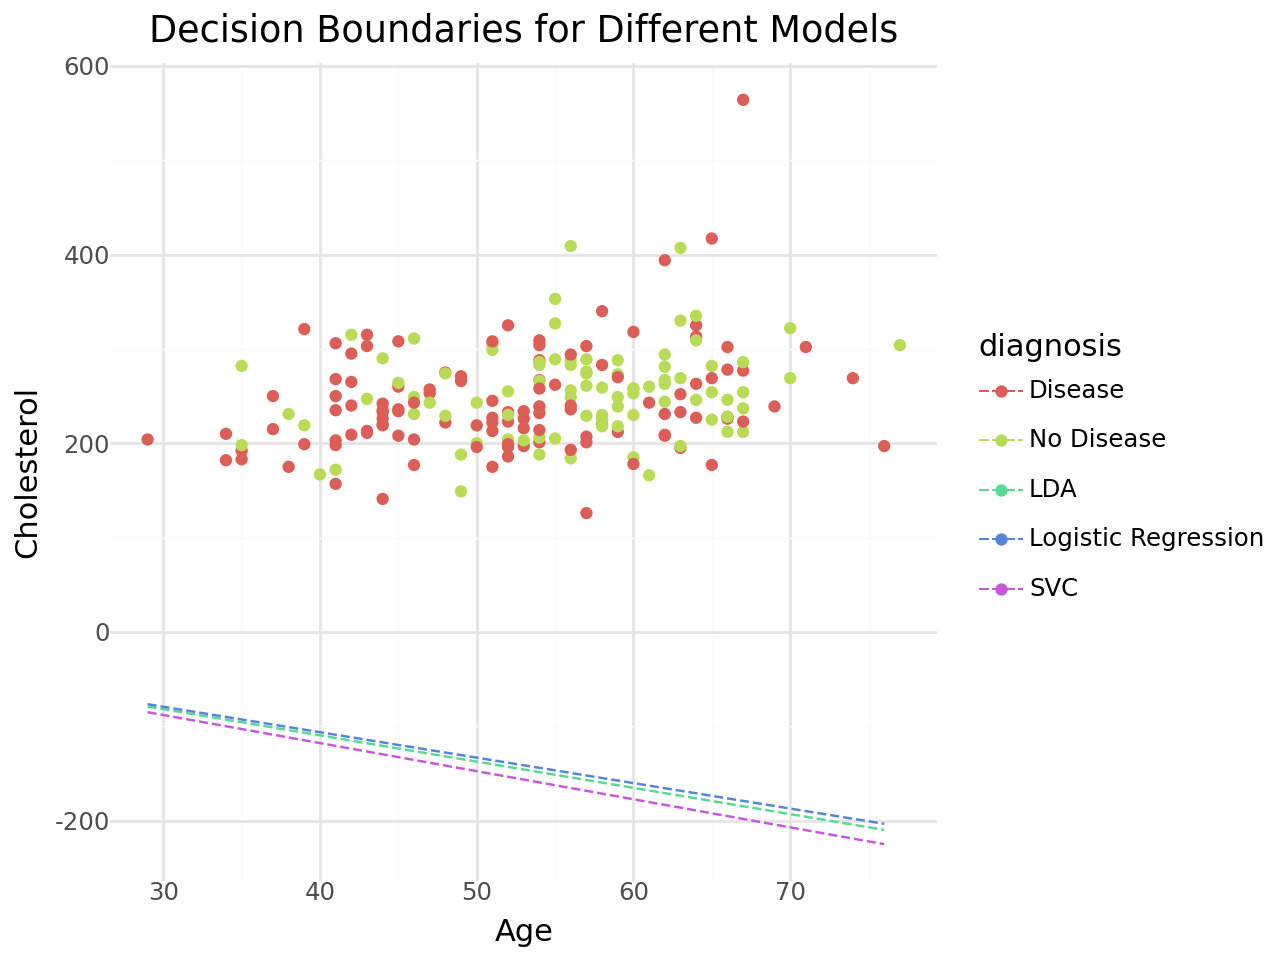

In [16]:
# Plotting
(ggplot(df, aes(x='age', y='chol', color='diagnosis')) +
 geom_point() +
 geom_line(aes(x='age', y='chol', color='model'), data=boundaries, linetype='dashed') +
 theme_minimal() +
 labs(title='Decision Boundaries for Different Models', x='Age', y='Cholesterol'))